# <font color='blue'>**Sentiment analysis on Textual Data using LSTM**</font> 

<font color='grey'>**Sentiment analysis**</font> is a natural language processing (NLP) task that involves determining the sentiment expressed in a piece of text.

"I love this product!" ---> <font color='green'>Positive</font>


"This is terrible."    ---> <font color='red'>Negative</font>

### Dataset

IMDB dataset having 50K movie reviews for natural language processing or Text analytics.

For detailed information about the dataset, please refer to the [dataset documentation](https://ai.stanford.edu/~amaas/data/sentiment/).

### <font color='blue'>Importing libraries</font>

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\waqar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### <font color='blue'>**Load data**</font>

In [2]:
# df = pd.read_csv('/content/drive/MyDrive/Post_doc_work/Seminar_RNN/data/IMDB_Dataset.csv')
df = pd.read_csv('./data/IMDB_Dataset.csv')
print(df.head())
print('\n Shape of dataset: ', np.shape(df))

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

 Shape of dataset:  (50000, 2)


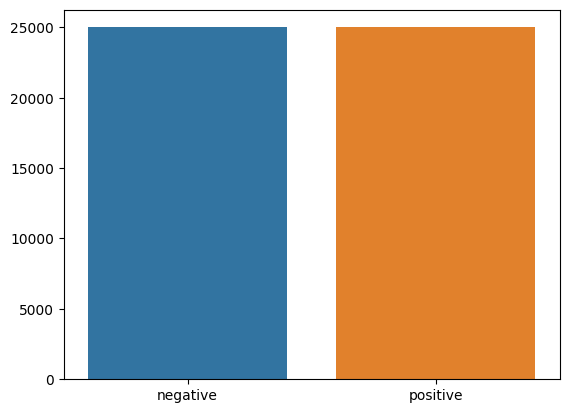

In [3]:
X,y = df['review'].values,df['sentiment'].values

dd = pd.Series(y).value_counts()    # Counts positive and negative sentiments
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()


### <font color='blue'>**Data preprocessing**</font> 

- <font color='blue'>**Lowercasing**</font>: Convert to lower case
- <font color='blue'>**Remove noise**</font>: Clean the text by removing punctuation, extra spaces, special characters, numbers, HTML tags, etc.
- <font color='blue'>**Tokenization**</font>: Transform sentences into individual words or tokens
- <font color='blue'>**Remove stop words**</font>: Remove common words (stop words) that do not carry significant meaning (e.g., 'is', 'and', 'the').
- These words are then assigned a unique identifier, forming a dictionary for one-hot encoding.


"The movie was excellent, and I really enjoyed it!" 

--> ['movie', 'excellent', 'really', 'enjoyed']


In [4]:
def data_preprocessing(text):
    text = text.lower()
    text = re.sub('<.*?>', '', text) # Remove HTML from text
    text = ''.join([c for c in text if c not in string.punctuation]) # Remove punctuation
    text = [word for word in text.split() if word not in stop_words]  # Remove stop words
    text = ' '.join(text)
    return text

df['cleaned_reviews'] = df['review'].apply(data_preprocessing)
df.head()

,review,sentiment,cleaned_reviews
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


### <font color='blue'>**Tokenize**</font>
- Create Vocab to Int mapping dictionary
- In most of the NLP tasks, we create an index mapping dictionary in such a way that frequently occurring words are assigned lower indexes. One of the most common way of doing this is to use Counter method from Collections library.

In [5]:
corpus = [word for text in df['cleaned_reviews'] for word in text.split()]
count_words = Counter(corpus)   # Count occurence of each words
sorted_words = count_words.most_common()

In [6]:
print(corpus[:5])
sorted_words[:5]

['one', 'reviewers', 'mentioned', 'watching', '1']


[('movie', 83506),
 ('film', 74462),
 ('one', 50366),
 ('like', 38825),
 ('good', 28483)]

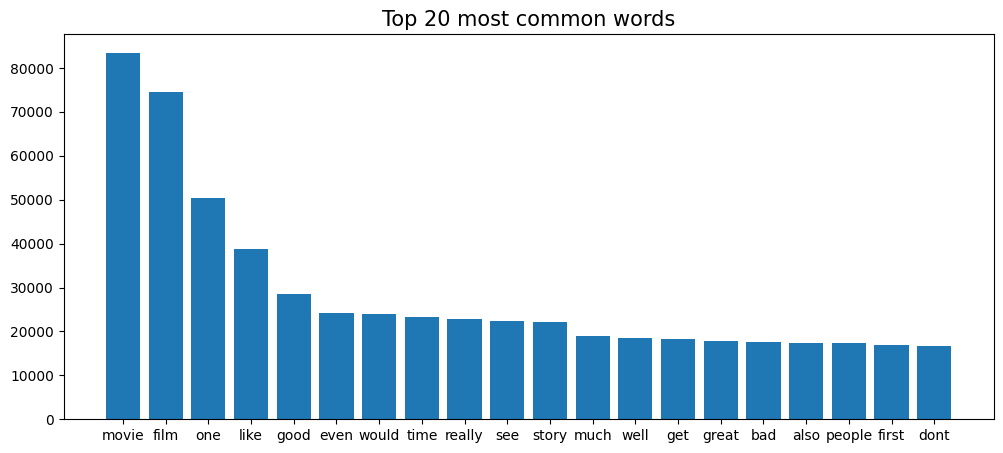

In [7]:
keys = []
values = []
for key, value in sorted_words[:20]:
    keys.append(key)
    values.append(value)

plt.figure(figsize=(12, 5))
plt.bar(keys, values)
plt.title('Top 20 most common words', size=15)
plt.show()

### <font color='blue'>**Mapping**</font>

In [8]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

reviews_int = []
for text in df['cleaned_reviews']:
    r = [vocab_to_int[word] for word in text.split()]  # Convert each review text into integer
    reviews_int.append(r)
print(reviews_int[:1])
df['Review int'] = reviews_int                      # (5000,)

[[3, 1809, 941, 56, 398, 3216, 286, 349, 3024, 107, 482, 471, 7412, 19, 57, 3097, 3216, 5384, 14831, 50, 473, 180, 107, 549, 52, 1605, 41, 8024, 5580, 11453, 41, 2358, 5834, 5492, 1339, 276, 473, 3259, 246, 233, 60896, 353, 3216, 11120, 240, 15438, 6674, 2418, 939, 60897, 2482, 1247, 24496, 422, 4557, 2375, 1080, 6877, 2828, 12558, 298, 60898, 16892, 213, 4901, 3569, 422, 236, 83230, 8153, 39824, 14832, 4989, 7605, 2318, 16893, 60899, 224, 8951, 7194, 12973, 8403, 33774, 34, 126, 21145, 7, 45, 166, 1173, 41, 551, 91, 159, 154, 436, 2842, 704, 84, 1144, 4165, 2352, 975, 704, 1282, 704, 83231, 58, 853, 87, 19, 286, 43, 103, 3097, 1451, 2067, 288, 45, 1422, 174, 1336, 1122, 3216, 88, 9930, 213, 1949, 1961, 473, 473, 7674, 6878, 4782, 13673, 2798, 31538, 6770, 13673, 380, 500, 14, 140, 13, 9589, 633, 694, 6770, 543, 1080, 19845, 551, 439, 809, 1860, 1080, 444, 56, 3216, 98, 302, 3602, 3115, 83232, 14, 1083, 3862, 392]]


In [9]:
df

,review,sentiment,cleaned_reviews,Review int
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching 1 oz episode ...,"[3, 1809, 941, 56, 398, 3216, 286, 349, 3024, ..."
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...,"[277, 37, 252, 1234, 2863, 17758, 83233, 1501,..."
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,"[96, 277, 26, 988, 8, 782, 1348, 2347, 1065, 8..."
3,Basically there's a family where a little boy ...,negative,basically theres family little boy jake thinks...,"[572, 124, 136, 37, 327, 3493, 1071, 124, 908,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...,"[83238, 33775, 35, 8, 187, 2020, 1251, 2, 29, ..."
...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,thought movie right good job wasnt creative or...,"[96, 1, 107, 5, 186, 172, 1347, 109, 19, 867, ..."
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic direc...,"[16, 38, 16, 296, 16, 36, 2839, 846, 515, 1431..."
49997,I am a Catholic taught in parochial elementary...,negative,catholic taught parochial elementary schools n...,"[3399, 4147, 42369, 8116, 4400, 8723, 4147, 56..."
49998,I'm going to have to disagree with the previou...,negative,im going disagree previous comment side maltin...,"[55, 70, 2856, 769, 800, 392, 11301, 3, 231, 9..."


### <font color='blue'>**Encode the labels**</font>

In [10]:
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
df.head()

,review,sentiment,cleaned_reviews,Review int
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching 1 oz episode ...,"[3, 1809, 941, 56, 398, 3216, 286, 349, 3024, ..."
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...,"[277, 37, 252, 1234, 2863, 17758, 83233, 1501,..."
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...,"[96, 277, 26, 988, 8, 782, 1348, 2347, 1065, 8..."
3,Basically there's a family where a little boy ...,0,basically theres family little boy jake thinks...,"[572, 124, 136, 37, 327, 3493, 1071, 124, 908,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter matteis love time money visually stunni...,"[83238, 33775, 35, 8, 187, 2020, 1251, 2, 29, ..."


### <font color='blue'>**Analyze Reviews Length**</font>

In [11]:
review_len = [len(x) for x in reviews_int]
df['Review len'] = review_len
df.head()

,review,sentiment,cleaned_reviews,Review int,Review len
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching 1 oz episode ...,"[3, 1809, 941, 56, 398, 3216, 286, 349, 3024, ...",168
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...,"[277, 37, 252, 1234, 2863, 17758, 83233, 1501,...",84
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...,"[96, 277, 26, 988, 8, 782, 1348, 2347, 1065, 8...",86
3,Basically there's a family where a little boy ...,0,basically theres family little boy jake thinks...,"[572, 124, 136, 37, 327, 3493, 1071, 124, 908,...",67
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter matteis love time money visually stunni...,"[83238, 33775, 35, 8, 187, 2020, 1251, 2, 29, ...",125


count    50000.000000
mean       119.855700
std         90.096619
min          3.000000
25%         64.000000
50%         89.000000
75%        146.000000
max       1429.000000
Name: Review len, dtype: float64


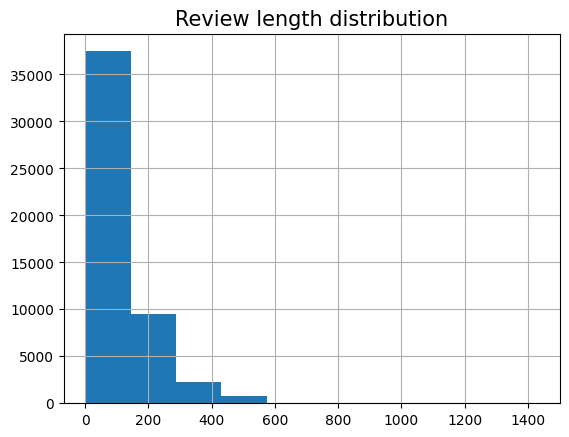

In [12]:
print(df['Review len'].describe())

df['Review len'].hist()
plt.title('Review length distribution', size=15)
plt.show()

### <font color='blue'>**Padding / Truncating**</font>

- RNN models typically require input sequences to have a consistent length.

- To deal with both short and long reviews, we will pad or truncate all reviews to a specific length.

- Define this length by Sequence Length. This sequence length is same as number of time steps for LSTM layer.

- For reviews shorter than seq_length, we will pad with 0s.

- For reviews longer than seq_length we will truncate them to the pre-defined sequence length.

In [13]:
def Padding(review_int, seq_len):
    '''
    Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(review_int), seq_len), dtype = int)
    for i, review in enumerate(review_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)
    return features

In [14]:
features = Padding(reviews_int, 200)
print(features[0, :])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     3  1809   941    56
   398  3216   286   349  3024   107   482   471  7412    19    57  3097
  3216  5384 14831    50   473   180   107   549    52  1605    41  8024
  5580 11453    41  2358  5834  5492  1339   276   473  3259   246   233
 60896   353  3216 11120   240 15438  6674  2418   939 60897  2482  1247
 24496   422  4557  2375  1080  6877  2828 12558   298 60898 16892   213
  4901  3569   422   236 83230  8153 39824 14832  4989  7605  2318 16893
 60899   224  8951  7194 12973  8403 33774    34   126 21145     7    45
   166  1173    41   551    91   159   154   436  2842   704    84  1144
  4165  2352   975   704  1282   704 83231    58   853    87    19   286
    43   103  3097  1451  2067   288    45  1422   174  1336  1122  3216
    88  9930   213  1949  1961   473   473  7674  6

## <font color='blue'>**Training, Validation, Test Split**</font>

In [15]:
X_train, X_remain, y_train, y_remain = train_test_split(features, df['sentiment'].to_numpy(), test_size=0.2, random_state=1)

X_valid, X_test, y_valid, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=1)

In [16]:
print('Trainig set size', len(X_train))
print('Validation set size', len(X_valid))
print('Test set size', len(X_test))


Trainig set size 40000
Validation set size 5000
Test set size 5000


## <font color='blue'>**Dataloaders and Batching**</font>

In [17]:
# create tensor dataset
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

# dataloaders
batch_size = 32

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [18]:
print('Number of training batches:', len(train_loader))
print('Number of test batches:', len(test_loader))
print('Number of validation batches:', len(valid_loader))

Number of training batches: 1250
Number of test batches: 157
Number of validation batches: 157


In [19]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)
print('Sample input label size: \n', sample_y.size())

Sample input size:  torch.Size([32, 200])
Sample input: 
 tensor([[    0,     0,     0,  ...,    22,    77,  3279],
        [    0,     0,     0,  ...,  1582,     3,   123],
        [    0,     0,     0,  ...,    44,   292, 39386],
        ...,
        [    0,     0,     0,  ...,   336,    54,  1433],
        [    0,     0,     0,  ...,   356,   788, 33071],
        [    2,  1308,  9256,  ...,  5235,  4214,   269]], dtype=torch.int32)
Sample input: 
 tensor([1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 1, 1])
Sample input label size: 
 torch.Size([32])


## <font color='blue'>**Define the Model Class**</font>

In [20]:
class sentimentLSTM(nn.Module):
    """
    The LSTM model used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # to map discrete categorical inputs (like word indices or class labels) into dense, low-dimensional continuous vector spaces. This allows the model to capture semantic meaning and relationships between categories.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

        # Linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        #embedding and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        #stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # Dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        #sigmoid function
        sig_out = self.sigmoid(out)

        # reshape to be batch size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels

        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [21]:
is_cuda = torch.cuda.is_available()

# If GPU available
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used \n")

# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int) + 1
output_size = 1
embedding_dim = 64
hidden_dim = 256
n_layers = 2

model = sentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model = model.to(device)

print(model)

GPU is available
sentimentLSTM(
  (embedding): Embedding(222610, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## <font color='blue'>**Training Loop**</font>

In [22]:
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

clip = 5
epochs = 5
valid_loss_min = np.inf

epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

torch.cuda.empty_cache()

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0

    model.train()
    for inputs, labels in train_loader:


        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        # initialize hidden state
        h = model.init_hidden(inputs.size(0))
        h_ = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h_)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())

        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy

        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()


    ### Validation
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
        
        val_h = model.init_hidden(inputs.size(0))
        va_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, va_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())

        accuracy = acc(output,labels)
        val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')

    # Directory check and creation
    save_path = '../working/state_dict.pt'
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

    if epoch_val_loss <= valid_loss_min:
        # torch.save(model.state_dict(), '../working/state_dict.pt')
        torch.save(model.state_dict(), save_path)
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.5985564096212387 val_loss : 0.44657180738297236
train_accuracy : 66.6125 val_accuracy : 78.92
Validation loss decreased (inf --> 0.446572).  Saving model ...
Epoch 2
train_loss : 0.3558467940211296 val_loss : 0.32846145222710954
train_accuracy : 84.75 val_accuracy : 85.98
Validation loss decreased (0.446572 --> 0.328461).  Saving model ...
Epoch 3
train_loss : 0.2479639279395342 val_loss : 0.30222208375573917
train_accuracy : 90.3175 val_accuracy : 87.14
Validation loss decreased (0.328461 --> 0.302222).  Saving model ...
Epoch 4
train_loss : 0.17819027681797742 val_loss : 0.31501933054369724
train_accuracy : 93.55499999999999 val_accuracy : 87.12
Epoch 5
train_loss : 0.12525197248384357 val_loss : 0.3616723547790461
train_accuracy : 95.6975 val_accuracy : 86.33999999999999


## <font color = 'blue'>**Testing**</font>

In [23]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

model.eval()

# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history

    # init hidden state
    test_h = model.init_hidden(inputs.size(0))

    tes_h = tuple([each.data for each in test_h])

    inputs, labels = inputs.to(device), labels.to(device)

    output, test_h = model(inputs, tes_h)

    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer

    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.320
Test accuracy: 0.880


In [24]:
from torch.cuda.amp import autocast
def predict_text(text):
        # Create a DataFrame with a single column 'reviews'
        sample_df = pd.DataFrame({'review': [text]})
        sample_df['cleaned_reviews'] = sample_df['review'].apply(data_preprocessing)

        review_integer = []
        for text in sample_df['cleaned_reviews']:
                r = [vocab_to_int[word] for word in text.split()]  # Convert each review text into integer
                review_integer.append(r)

        sample_df['Review int'] = review_integer
        features = Padding(review_integer, 200)
        inference_loader = DataLoader(features, shuffle=True, batch_size=50)

        # init hidden state
        # batch_size = 1
        # inference_h = model.init_hidden(batch_size)

        model.eval()
        for inputs in inference_loader:

                inf_h = model.init_hidden(inputs.size(0))
                inference_h = tuple([each.data for each in inf_h])

                inputs = inputs.to(device)

                output, inference_h = model(inputs, inference_h)
                pred = output.item()
        
        return  pred

In [25]:
index = 35
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
# pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status}')

I bought this film at Blockbuster for $3.00, because it sounded interesting (a bit Ranma-esque, with the idea of someone dragging around a skeleton), because there was a cute girl in a mini-skirt on the back, and because there was a Restricted Viewing sticker on it. I thought it was going to be a sweet or at least sincere coming of age story with a weird indie edge. I was 100% wrong.<br /><br />Having watched it, I have to wonder how it got the restricted sticker, since there is hardly any foul language, little violence, and the closest thing to nudity (Honestly! I don't usually go around hoping for it!) is when the girl is in her nightgown and you see her panties (you see her panties a lot in this movie, because no matter what, she's wearing a miniskirt of some sort). Even the anti-religious humor is tame (and lame, caricatured, insincere, derivative, unoriginal, and worst of all not funny in the slightest--it would be better just to listen to Ray Stevens' "Would Jesus Wear a Rolex on

In [29]:
index = 30
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
# pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status}')

Taut and organically gripping, Edward Dmytryk's Crossfire is a distinctive suspense thriller, an unlikely "message" movie using the look and devices of the noir cycle.<br /><br />Bivouacked in Washington, DC, a company of soldiers cope with their restlessness by hanging out in bars. Three of them end up at a stranger's apartment where Robert Ryan, drunk and belligerent, beats their host (Sam Levene) to death because he happens to be Jewish. Police detective Robert Young investigates with the help of Robert Mitchum, who's assigned to Ryan's outfit. Suspicion falls on the second of the three (George Cooper), who has vanished. Ryan slays the third buddy (Steve Brodie) to insure his silence before Young closes in.<br /><br />Abetted by a superior script by John Paxton, Dmytryk draws precise performances from his three starring Bobs. Ryan, naturally, does his prototypical Angry White Male (and to the hilt), while Mitchum underplays with his characteristic alert nonchalance (his role, howeve

In [26]:
sample_text = 'I like the actors that work in it but I do not like this movie.'

prob = predict_text(sample_text)
status = "positive" if prob > 0.5 else "negative"
print(sample_text)
print(f'Predicted sentiment is {status}')
print('Probability', prob)

I like the actors that work in it but I do not like this movie.
Predicted sentiment is negative
Probability 0.1872550994157791


In [27]:
sample_text = "He has lack of sportsmanship and have not good qualities."


prob = predict_text(sample_text)
status = "positive" if prob > 0.5 else "negative"
print(sample_text)
print(f'Predicted sentiment is {status}')
print('Probability', prob)

He has lack of sportsmanship and have not good qualities.
Predicted sentiment is negative
Probability 0.1582513004541397
